2023-12-15 09:38:50,112 INFO     pid:154541 __main__:082:initModel Using CUDA; 3 devices.


end_to_end_Net
clear_tof_amp_npys size:230
clear_tof_pha_npys size:230
fog_tof_amp_npys_path size:230
fog_tof_pha_npys_path size:230
clear_tof_amp_npys size:10
clear_tof_pha_npys size:10
fog_tof_amp_npys_path size:10
fog_tof_pha_npys_path size:10
Epoch: [1]  [0/3]  eta: 0:00:14  lr: 0.000033  loss: 7.0366 (7.0366)  time: 4.9712  data: 1.7049  max mem: 33008
Epoch: [1] Total time: 0:00:08
Test:  [0/1]  eta: 0:00:00  loss: 3.8963 (3.8963)  time: 0.4130  data: 0.3158  max mem: 33085
Test: Total time: 0:00:00
Epoch: [2]  [0/3]  eta: 0:00:12  lr: 0.000099  loss: 8.0588 (8.0588)  time: 4.0032  data: 1.5426  max mem: 33085
Epoch: [2] Total time: 0:00:07
Test:  [0/1]  eta: 0:00:00  loss: 3.7223 (3.7223)  time: 0.3900  data: 0.3249  max mem: 33085
Test: Total time: 0:00:00
Epoch: [3]  [0/3]  eta: 0:00:11  lr: 0.000098  loss: 6.3877 (6.3877)  time: 3.9471  data: 1.4856  max mem: 33085
Epoch: [3] Total time: 0:00:07
Test:  [0/1]  eta: 0:00:00  loss: 3.8162 (3.8162)  time: 0.3738  data: 0.3077  ma

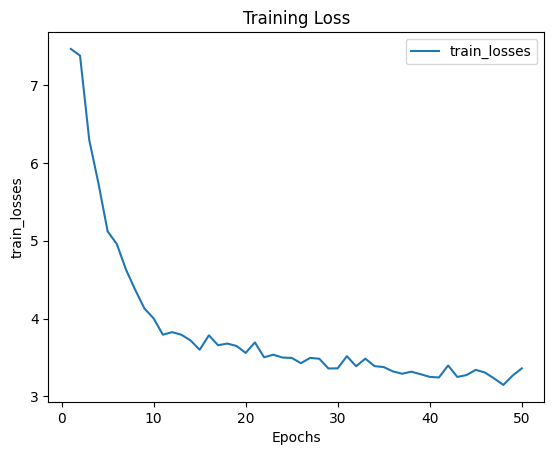

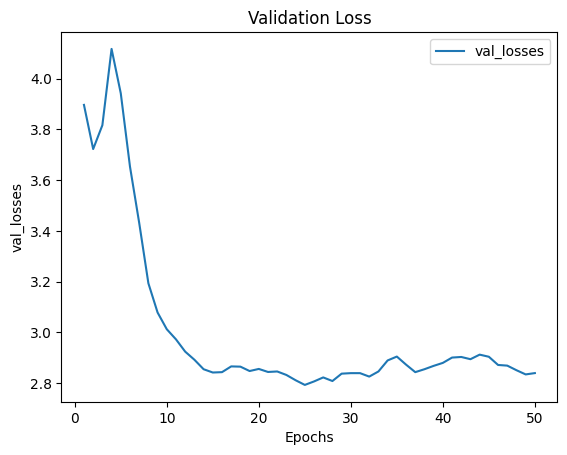

In [1]:
import datetime
import time
import os
import torch
import torch.utils.data.dataloader as DataLoader
import sys
import argparse
import transforms as T
import matplotlib.pyplot as plt
import numpy as np

from model import SimpleNet
# from simple_model import SimpleNet
from Src.ComplexValuedAutoencoderMain_Torch import end_to_end_Net
from dataset import ToFDataset
from train_and_eval import train_one_epoch, evaluate, create_lr_scheduler
from util.logconf import logging


log = logging.getLogger(__name__)
# log.setLevel(logging.WARN)
log.setLevel(logging.INFO)
log.setLevel(logging.DEBUG)

torch.cuda.set_device(2)

class PresetTrain:
    def __init__(self, crop_size, hflip_prob=0.5):
        
        trans = []
        if hflip_prob > 0:
            trans.append(T.RandomHorizontalFlip(hflip_prob))
        trans.extend([
            T.RandomCrop(crop_size),
            
        ])
        self.transforms = T.Compose(trans)

    def __call__(self, img, target):
        return self.transforms(img, target)


class PresetEval:
    def __init__(self, crop_size):
        trans = []
        trans.extend([
            T.CenterCrop(crop_size),
        ])
        self.transforms = T.Compose(trans)

    def __call__(self, img, target):
        return self.transforms(img, target)

def get_transform(train):
    crop_size = 240

    if train:
        return PresetTrain(crop_size)
    else:
        return PresetEval(crop_size)

class TrainingApp:
    def __init__(self, sys_argv=None):

        if sys_argv is None:
            sys_argv = sys.argv[1:]
            
        self.lr = 0.0001
        self.path = './data'
        self.batch_size = 100
        self.epochs = 50
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device('cuda' if self.use_cuda else 'cpu')
        self.num_workers = 8
        self.model = self.initModel()
        self.optimizer = self.initOptimizer(self.lr)
      

    def initModel(self):
        model = end_to_end_Net(1,1,1,bilinear=True)
        if self.use_cuda:
            log.info("Using CUDA; {} devices.".format(
                torch.cuda.device_count()))
#             if torch.cuda.device_count() > 1:
#                 model = torch.nn.parallel.DistributedDataParallel(model)
            model = model.to(self.device)
        return model

    def initOptimizer(self, lr):
        optimizer = torch.optim.Adam(self.model.parameters(), lr)
        return optimizer
    

    def initTrainDL(self):
        train_dataset = ToFDataset(self.path, train=True, transforms=get_transform(train=True))

        batch_size = self.batch_size
        if self.use_cuda:
                batch_size *= torch.cuda.device_count()

        train_DL = torch.utils.data.DataLoader(train_dataset,
                              batch_size=self.batch_size,
                              shuffle=True,
                              num_workers=self.num_workers,
                              pin_memory=self.use_cuda)
        return train_DL

    def initValDL(self):
        val_dataset = ToFDataset(self.path, train=False, transforms=get_transform(train=False))

        batch_size = self.batch_size
        if self.use_cuda:
            batch_size *= torch.cuda.device_count()

        val_DL = torch.utils.data.DataLoader(val_dataset,
                            batch_size=self.batch_size,
                            num_workers=self.num_workers,
                            pin_memory=self.use_cuda)
        return val_DL

    def showPlt(self, train_losses, val_losses):
        epochs = np.arange(1, self.epochs+1)
        plt.figure()
        plt.plot(epochs, train_losses, label='train_losses')
        plt.xlabel('Epochs')
        plt.ylabel('train_losses')
        plt.title('Training Loss')
        plt.legend()
        
        plt.figure()
        plt.plot(epochs, val_losses, label='val_losses')
        plt.xlabel('Epochs')
        plt.ylabel('val_losses')
        plt.title('Validation Loss')
        plt.legend()
        
        plt.show()    
    def main(self):
        # log.info("Starting {}, {}".format(type(self).__name__, self.cli_args))
        results_file = "results{}.txt".format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        
        train_DL = self.initTrainDL()
        val_DL = self.initValDL()
        min_loss = 10000

        start_time = time.time()
        train_losses = []
        val_losses = []
        self.lr_scheduler = create_lr_scheduler(self.optimizer, num_step=len(train_DL), epochs=self.epochs, warmup=True)
        
        for epoch_ndx in range(1, self.epochs + 1):
            loss, lr = train_one_epoch(self.model, self.optimizer, train_DL, self.device, epoch_ndx, self.lr_scheduler, scaler=None)
            
            val_loss = evaluate(self.model, val_DL, self.device)
            
            train_losses.append(loss)
            val_losses.append(val_loss)
            
            # with open(results_file, "a") as f:
            #     train_info = f"[epoch: {epoch_ndx}]\n" \
            #                 f"train_loss: {loss:.4f}\n" \
            #                 f"lr: {lr:.6f}\n"
            #     f.write(train_info)

            save_file = {"model": self.model.state_dict(),
                        "optimizer": self.optimizer.state_dict(),
                        "lr_scheduler": self.lr_scheduler.state_dict(),
                        "epoch": epoch_ndx,
                        # "args": args
                        }
            
            if val_loss < min_loss:
                min_loss = val_loss
                torch.save(save_file, "save_weights/best_model.pth")
            # torch.save(save_file, "./save_weights/model_{}.pth".format(epoch_ndx))
            # if args.amp:
            #     save_file["scaler"] = scaler.state_dict()

            # if args.save_best is True:
            #     torch.save(save_file, "./save_weights/best_model.pth")
            # else:
            #     torch.save(save_file, "./save_weights/model_{}.pth".format(epoch_ndx))

        
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print("Training time {}".format(total_time_str))
        self.showPlt(train_losses, val_losses)

    # def doTraining(self, epoch_ndx, train_DL):
    #     self.model.train()

if __name__ == '__main__':
    if not os.path.exists('./save_weights'):
        os.makedirs('./save_weights')
    TrainingApp().main()
